In [47]:
!date

Sat Oct 23 15:17:28 PDT 2021


# Leiden clustering only experiment data
#### Unfiltered data obtained from using kb with multimapping function. Ref genome includes WRE.

___

In [48]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [49]:
import sys
import anndata
import scvi

import scanpy as sc
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pandas as pd

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [50]:
# set random seed
np.random.seed(926)

___

# Load Anndata object from h5ads

Load data from experiment animal 1:

In [51]:
adata_3E = anndata.read('../../finchseq_data/kallisto_bustools/mm_FT-SA112358-ZSOFIA-3E/counts_unfiltered/adata.h5ad')
adata_3E

AnnData object with n_obs × n_vars = 999106 × 22151
    var: 'gene_name'

Load data from experiment animal 2:

In [52]:
adata_4E = anndata.read('../../finchseq_data/kallisto_bustools/mm_FT-SA112359-ZSOFIA-4E/counts_unfiltered/adata.h5ad')
adata_4E

AnnData object with n_obs × n_vars = 1282885 × 22151
    var: 'gene_name'

Add columns to obs:

In [53]:
adata_3E.obs["species"] = ["zebrafinch"] * adata_3E.n_obs
adata_3E.obs["batch"] = ["experiment1"] * adata_3E.n_obs

adata_4E.obs["species"] = ["zebrafinch"] * adata_4E.n_obs
adata_4E.obs["batch"] = ["experiment2"] * adata_4E.n_obs

In [54]:
adatas = [adata_3E, adata_4E]

___

# Basic Filtering

### Knee plots

In [55]:
# Expected number of cells in order of experiment1, experiment2:
expected_num_cells = [7707, 12306] # based on cell counts obtained after bustools filtering

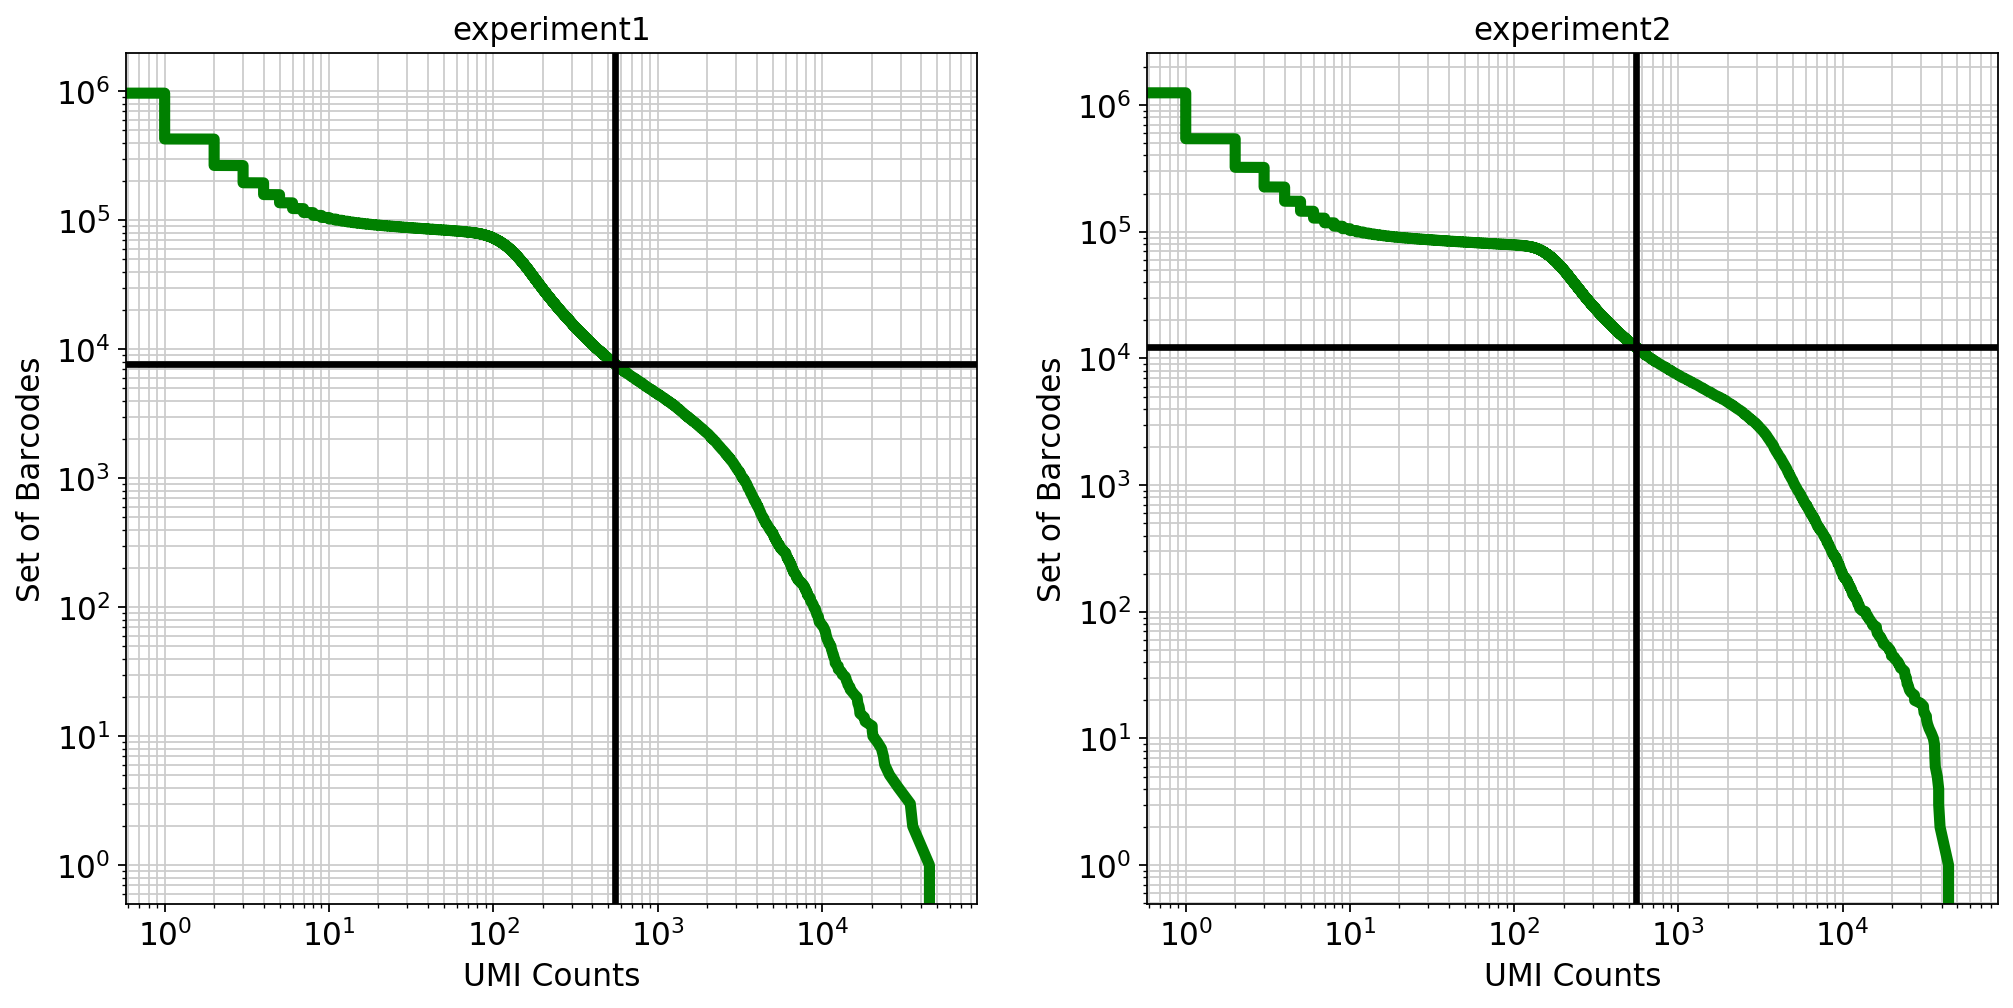

In [56]:
fig, axs = plt.subplots(figsize=(15,7), ncols=2)
i = 0

for ax,adata in zip(axs, adatas):

    knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
    
    ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
    ax.axvline(x=knee[expected_num_cells[i]], linewidth=3, color="k")
    ax.axhline(y=expected_num_cells[i], linewidth=3, color="k")

    ax.set_xlabel("UMI Counts")
    ax.set_ylabel("Set of Barcodes")
    ax.set_title("{}".format(adata.obs.batch.values[0]))
    
    ax.grid(True, which="both")
    
    i =+ 1

fig.show()

Knee plot ref: https://liorpachter.wordpress.com/2019/06/24/rotating-the-knee-plot-and-related-yoga/

Minimum number of UMI counts based on knee plot:

In [57]:
knee = np.sort((np.array(adata_3E.X.sum(axis=1))).flatten())[::-1]
min_umi = knee[expected_num_cells[0]]
print("The minimum number of UMI counts based on the knee plot for {} is: ".format(adata_3E.obs.batch.values[0])+str(min_umi))

# Removes cells with less than min_umi umi counts
adata_3E = adata_3E[np.asarray(adata_3E.X.sum(axis=1)).reshape(-1) > min_umi]

# Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
adata_3E.obs['n_counts_processed'] = adata_3E.X.sum(axis=1)

print(adata_3E)

The minimum number of UMI counts based on the knee plot for experiment1 is: 549.0


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 7706 × 22151
    obs: 'species', 'batch', 'n_counts_processed'
    var: 'gene_name'


In [58]:
knee = np.sort((np.array(adata_4E.X.sum(axis=1))).flatten())[::-1]
min_umi = knee[expected_num_cells[1]]
print("The minimum number of UMI counts based on the knee plot for {} is: ".format(adata_4E.obs.batch.values[0])+str(min_umi))

# Removes cells with less than min_umi umi counts
adata_4E = adata_4E[np.asarray(adata_4E.X.sum(axis=1)).reshape(-1) > min_umi]

# Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
adata_4E.obs['n_counts_processed'] = adata_4E.X.sum(axis=1)

print(adata_4E)

The minimum number of UMI counts based on the knee plot for experiment2 is: 549.0


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 12288 × 22151
    obs: 'species', 'batch', 'n_counts_processed'
    var: 'gene_name'


n_obs is pretty close to the expected number of cells (approx 10k).

#### Mean UMIs for each batch

In [59]:
print("Mean UMI count per cell for experiment1: " + str(adata_3E.X.sum(axis=1).mean()))
print("Mean UMI count per cell for experiment2: " + str(adata_4E.X.sum(axis=1).mean()))

Mean UMI count per cell for experiment1: 1852.4244
Mean UMI count per cell for experiment2: 2265.4285


#### Total UMI count for each batch

In [60]:
print("Total UMI count per cell for experiment1: ", adata_3E.X.sum())
print("Total UMI count per cell for experiment2: ", adata_4E.X.sum())

Total UMI count per cell for experiment1:  14274784.0
Total UMI count per cell for experiment2:  27837586.0


___

# Concatenate AnnData objects

In [61]:
# Join = outer uses union of datasets (not just intersection); empty values will be filled with np.nan
adata_exp = adata_3E.concatenate(adata_4E, 
                                     join='outer', 
                                     batch_key='batch_index', 
                                     batch_categories=None, 
                                     uns_merge=None, 
                                     fill_value=np.nan)

In [62]:
# Add column containing sum of molecules across all genes
adata_exp.obs["n_counts_raw"] = adata_exp.X.sum(axis=1)

In [63]:
# Create new index consisting of gene_name and gene_id separated by "_" (previous index was just gene_id)
adata_exp.var["gene_id"] = adata_exp.var.index.values
adata_exp.var.index = adata_exp.var.gene_name.astype(str) + "_" + adata_exp.var.gene_id.astype(str)
del adata_exp.var["gene_id"]

___

# Normalization

Show highest expressing genes before normalization:

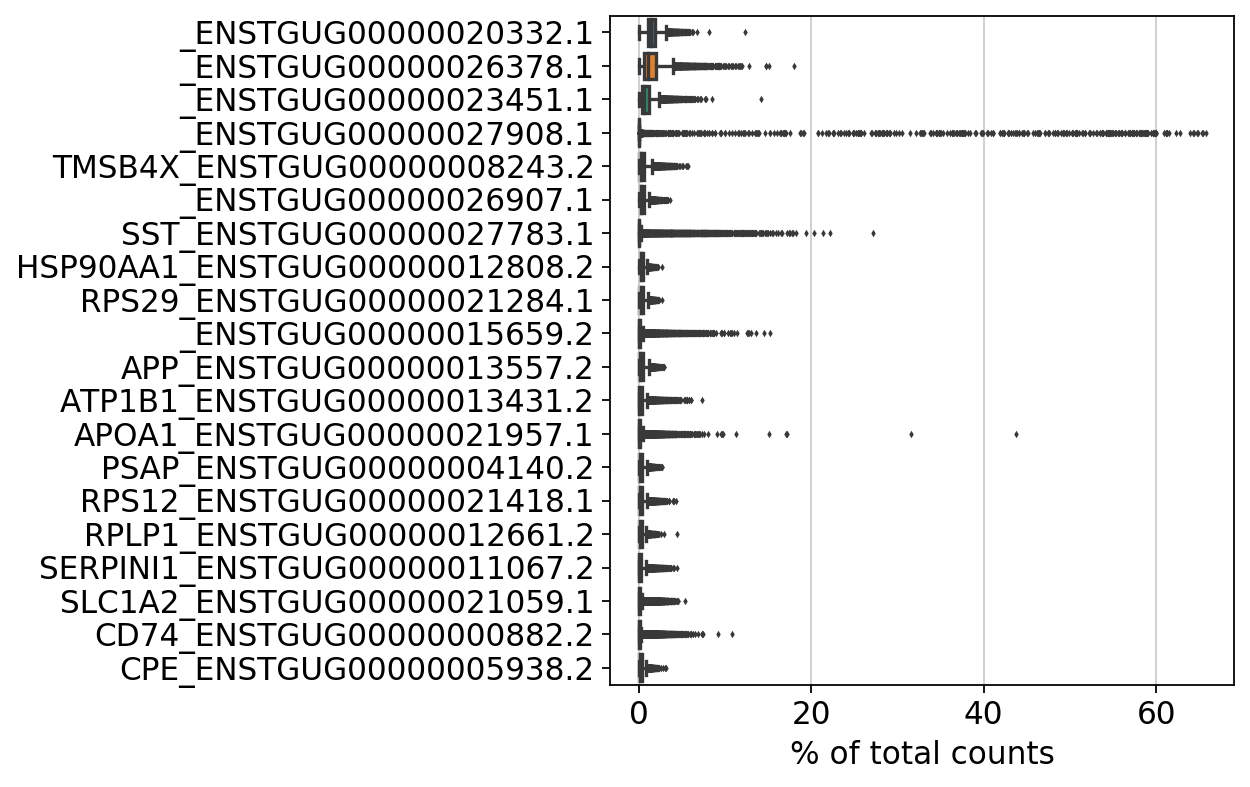

In [64]:
sc.pl.highest_expr_genes(adata_exp, n_top=20)

Divide each gene count by the total # of UMI's for that cell. Then take log(X+1) (+1 because you cannot take log(0)) (=log transformation). Note: Doing CP10k instead of CPM because Leiden clustering gives ~50 clusters if I use CPM for some unkown reason.

In [65]:
adata_exp.layers["raw"] = adata_exp.X.copy()
sc.pp.normalize_total(adata_exp, target_sum=10**4) # CP10k normalization: sum counts for each cell, divide each entry by this sum, multiply by 10k
sc.pp.log1p(adata_exp) # log(expression + 1)

Highest expressed genes after normalization and log:

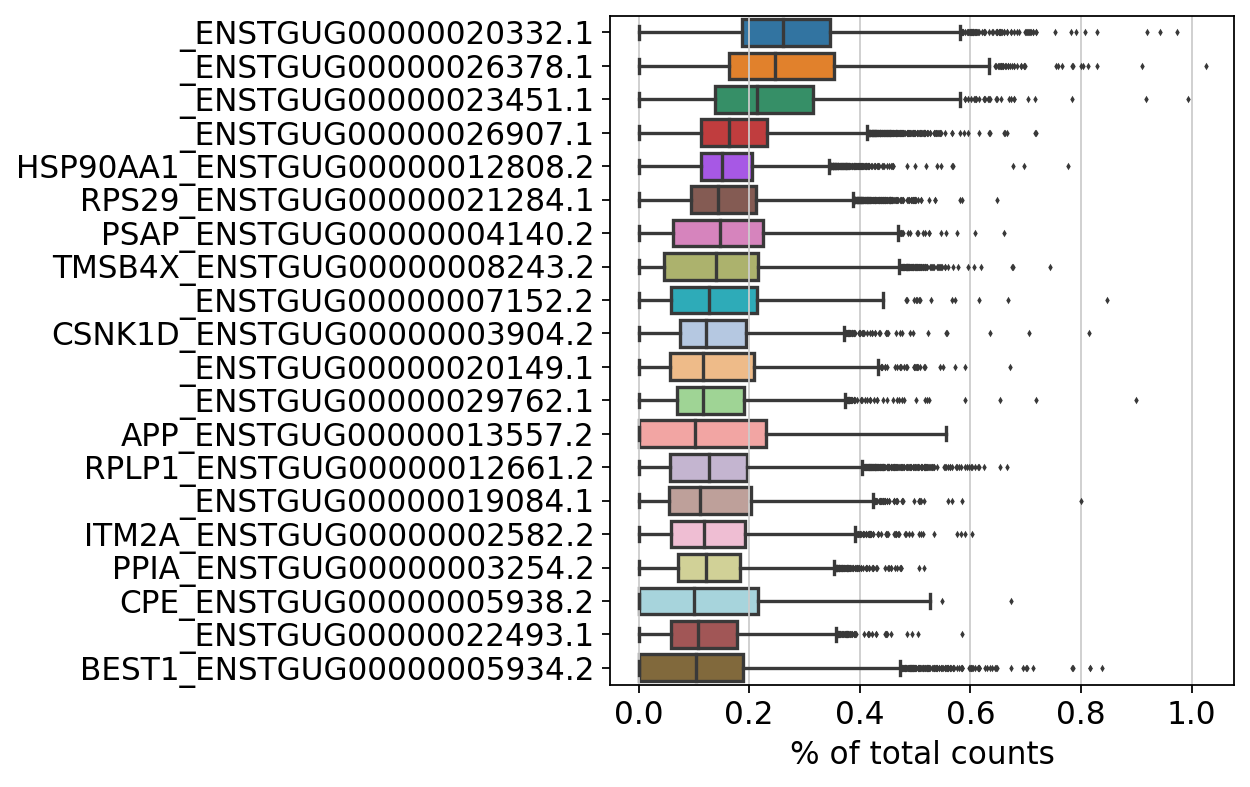

In [66]:
sc.pl.highest_expr_genes(adata_exp, n_top=20)

Annotate highly variable genes:

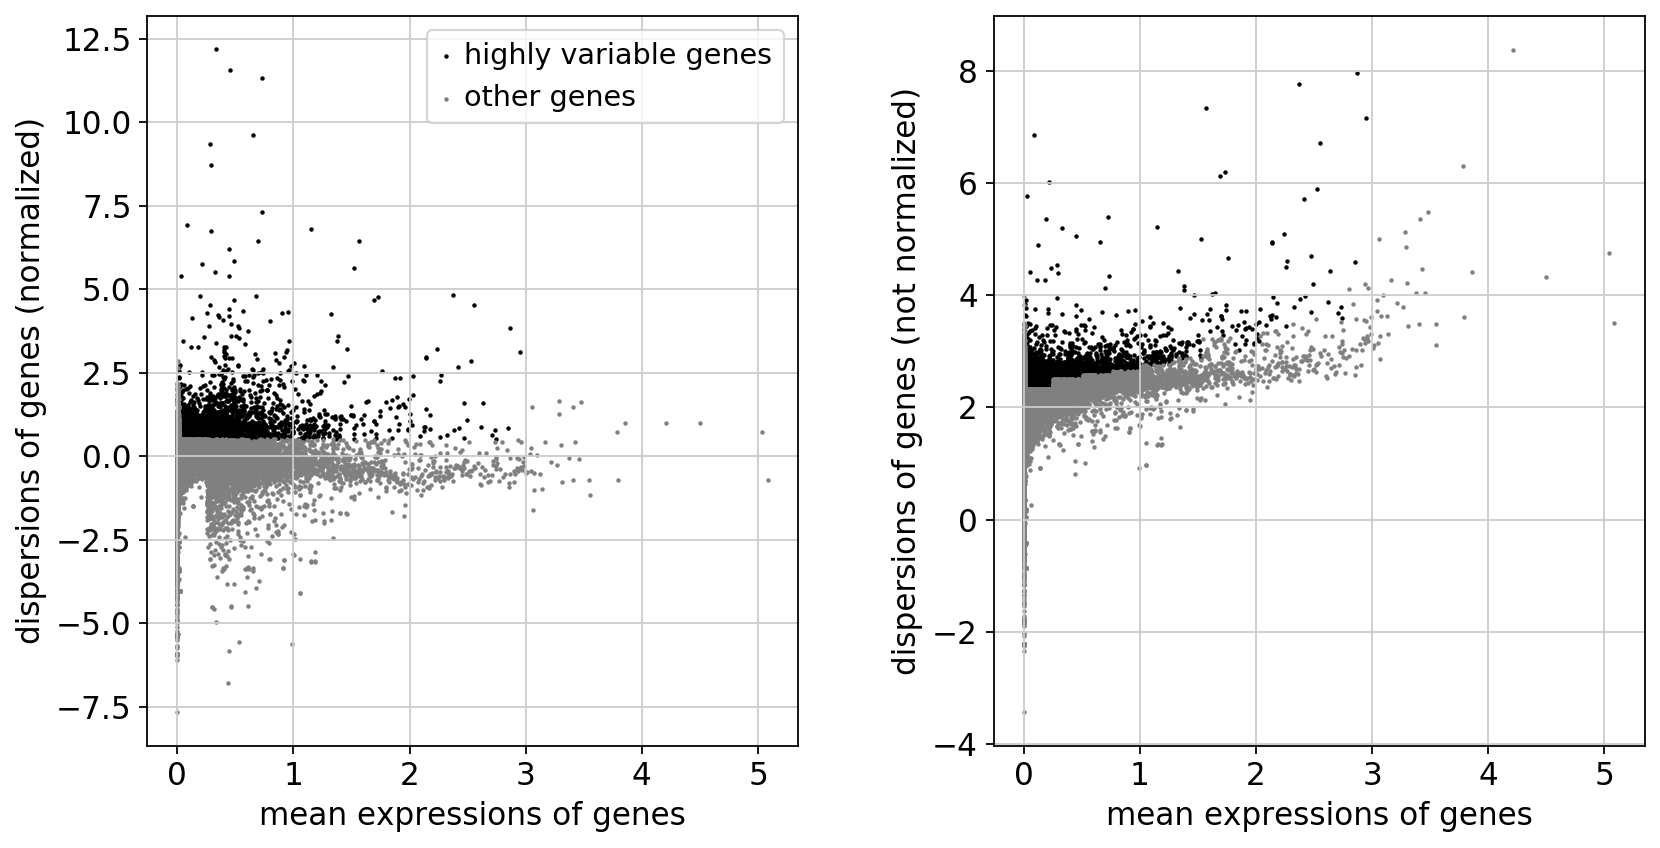

In [67]:
sc.pp.highly_variable_genes(adata_exp)
sc.pl.highly_variable_genes(adata_exp)

___

# Clustering

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [68]:
# Perform PCA on just the highly variable genes
sc.tl.pca(adata_exp, use_highly_variable=True)

Plot the variance ratio:

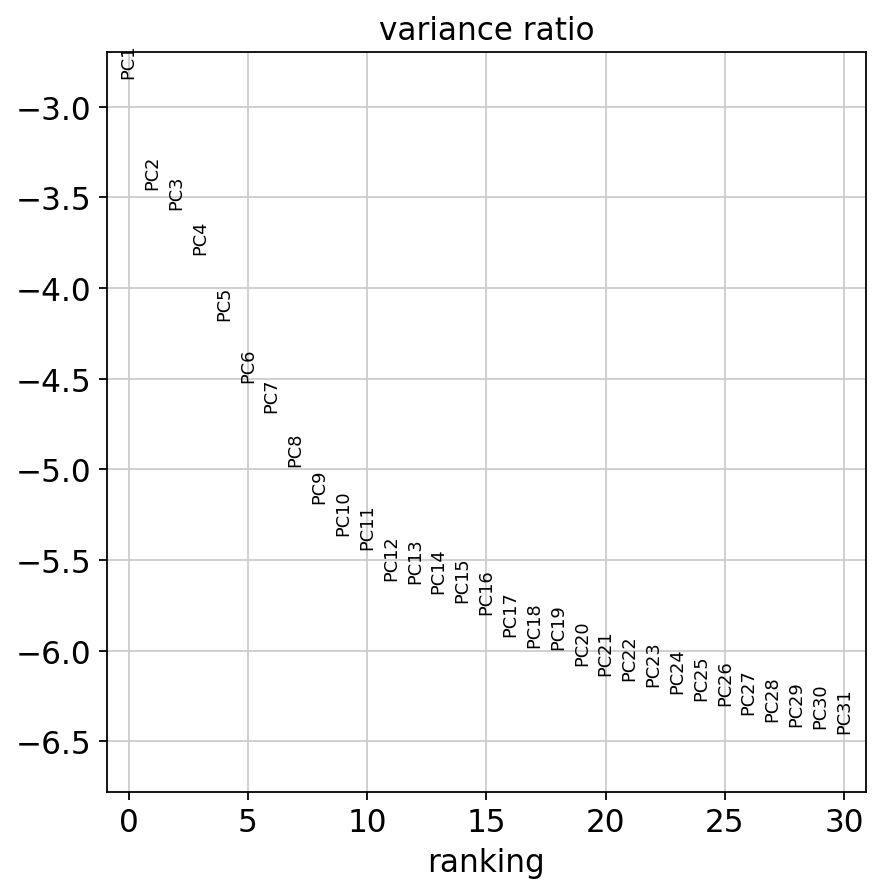

In [69]:
# Control
sc.pl.pca_variance_ratio(adata_exp, log=True)

In [70]:
# Define number of nearest neighbours based on the variance ratio plot above
n_neighbors = 20
n_pcs = 10

In [71]:
# Find nearest neighbors
sc.pp.neighbors(adata_exp, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=0)

In [72]:
# Leiden clustering on the neighboorhood graph
sc.tl.leiden(adata_exp, random_state=0)

___

# UMAP

In [77]:
# Project leiden clustering into 2D
sc.tl.umap(adata_exp)

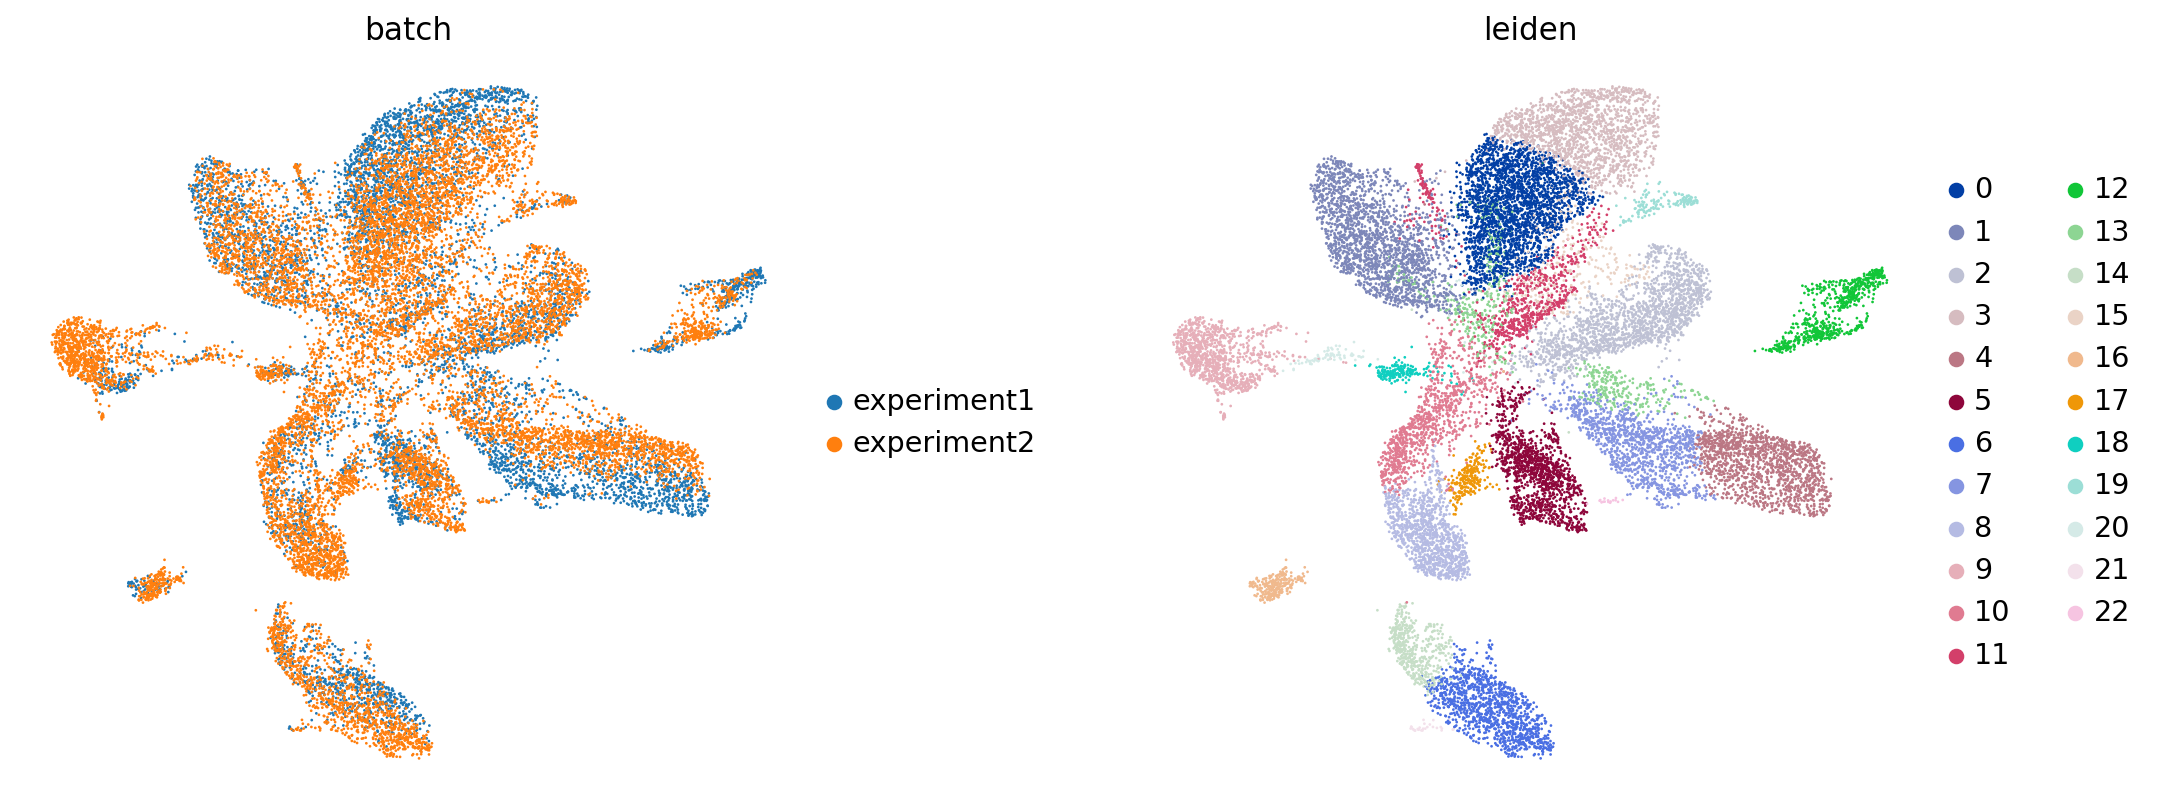

In [78]:
# Plot UMAP and color by Leiden clusters and batch
sc.pl.umap(adata_exp, 
           color=["batch", "leiden"],
           wspace=0.3
          )

___
# Save AnnData object

In [79]:
# adata_exp.write("../../finchseq_data/exp_leiden.h5ad")